### Задание для курсового проекта

Метрика:
rmse -корень среднеквадратичного отклонения

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/data


**Построение модели регресси**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Подбор моделей, получение бейзлана
7. Проверка качества, борьба с переобучением
8. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Загружаем библиотеки

In [128]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.image as img
from scipy import stats

In [129]:
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D


In [130]:
import warnings
warnings.filterwarnings('ignore')

In [131]:
matplotlib.rcParams.update({'font.size': 14})

In [132]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [133]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Загрузка данных
**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [134]:
TRAIN_DATASET_PATH = 'C:/Users/PosadskovEvS/Desktop/Рабочая СД/Матрица компетенций/DS/Kaggle/Соревнование от Gb/data/train.csv'
TEST_DATASET_PATH = 'C:/Users/PosadskovEvS/Desktop/Рабочая СД/Матрица компетенций/DS/Kaggle/Соревнование от Gb/data/test.csv'

In [135]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [136]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [137]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [138]:
train_df.shape

(10000, 20)

In [139]:
test_df.shape

(5000, 19)

## Проводим EDA
### 1) Приводим типы данных

In [140]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [141]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [142]:
train_df.shape

(10000, 20)

In [143]:
test_df.shape

(5000, 19)

In [144]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


### 2) Визуализируем данные, проверяем данные на логичность и наличие пропусков на основе describe и info, например: площадь не должна быть равна 0, кол-во этажей не может быть 0 и пр.

### Смотрим распределение целевой переменной
Наблюдение: большинство значений целевой переменной смещено влево, что означает что среднее лучше не брать для заполнения пропусков.

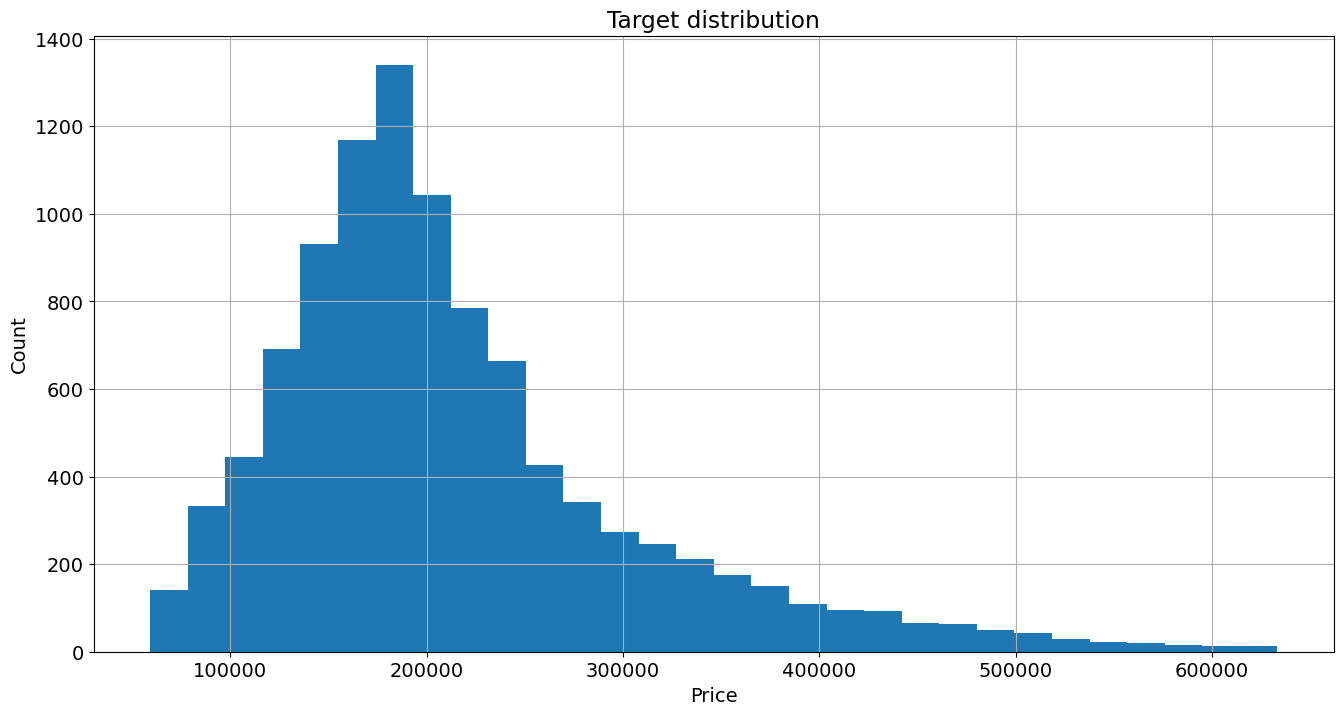

In [145]:
plt.figure(figsize=(16, 8))

train_df['Price'].hist(bins = 30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [146]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [147]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [148]:
num_feat = list(train_df.select_dtypes(exclude='object').columns)
obj_feat = list(train_df.select_dtypes(include='object').columns)
target = 'Price'

num_feat

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

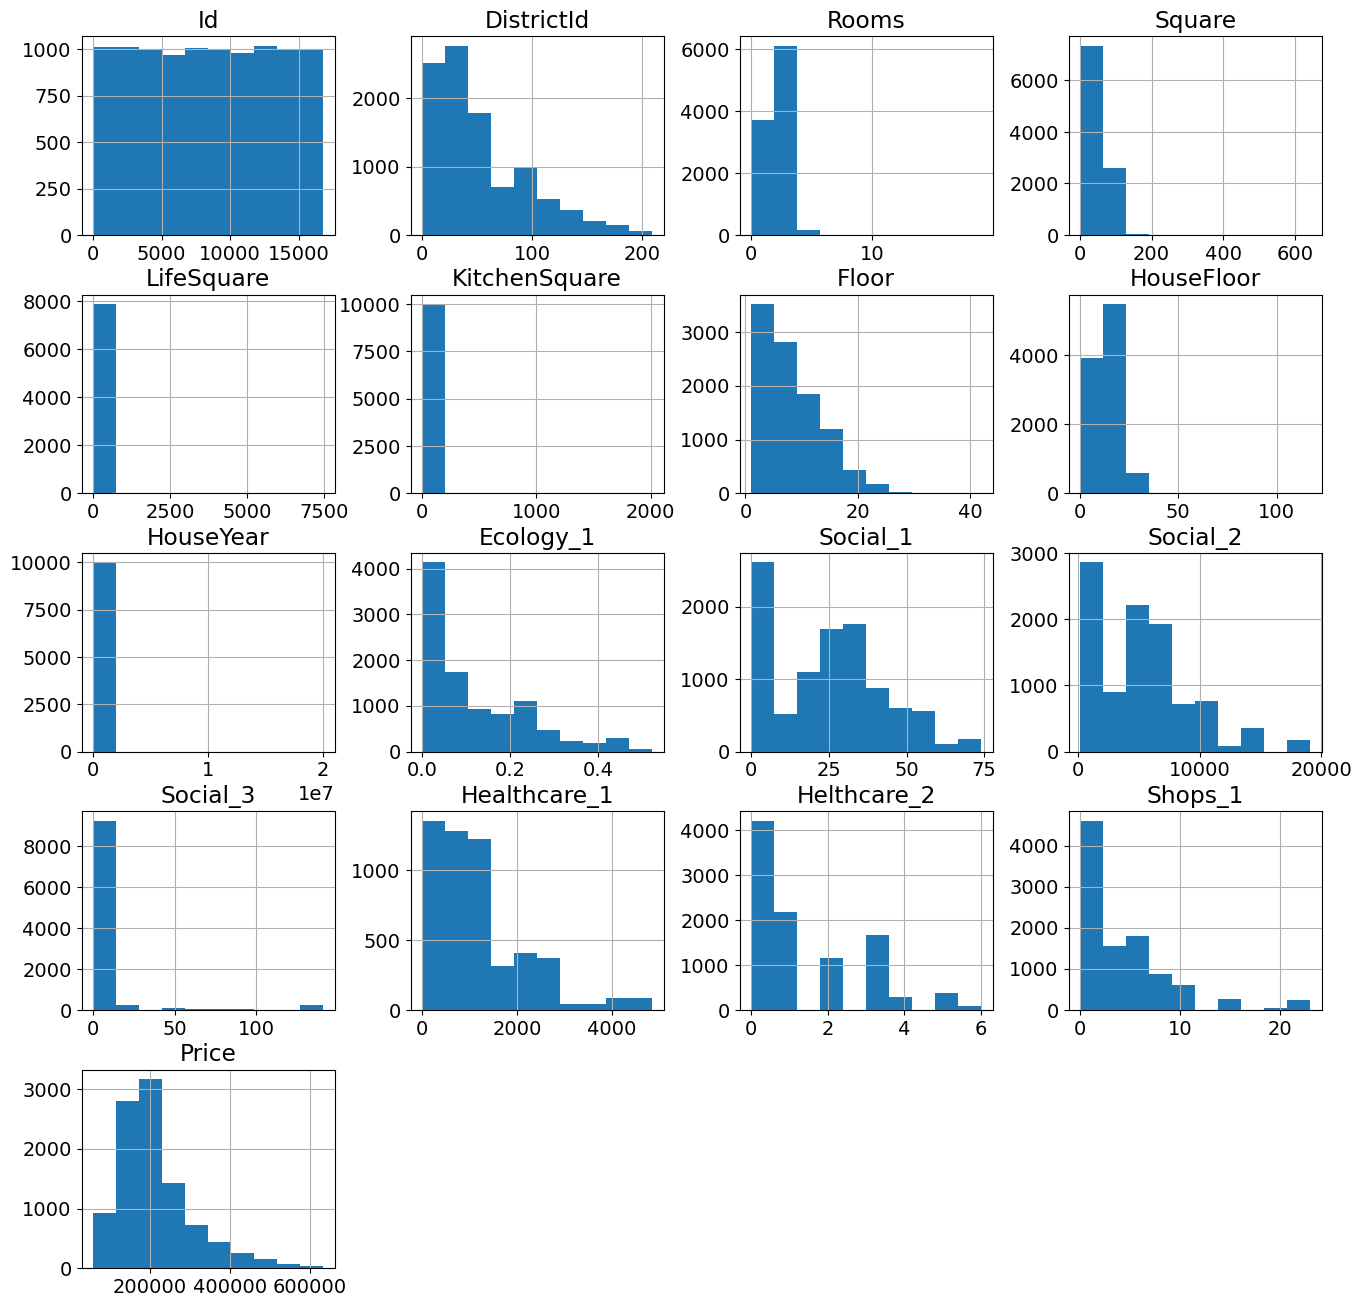

In [149]:
train_df[num_feat].hist(
    figsize=(16,16)
)
plt.show()

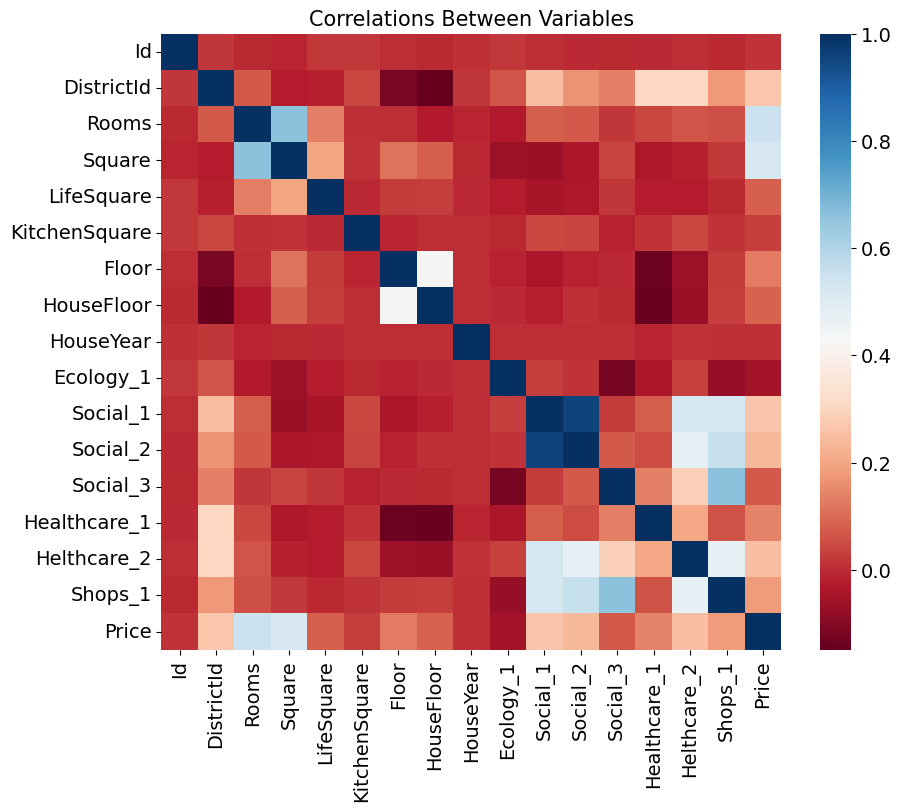

In [150]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df[num_feat].corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

<Axes: >

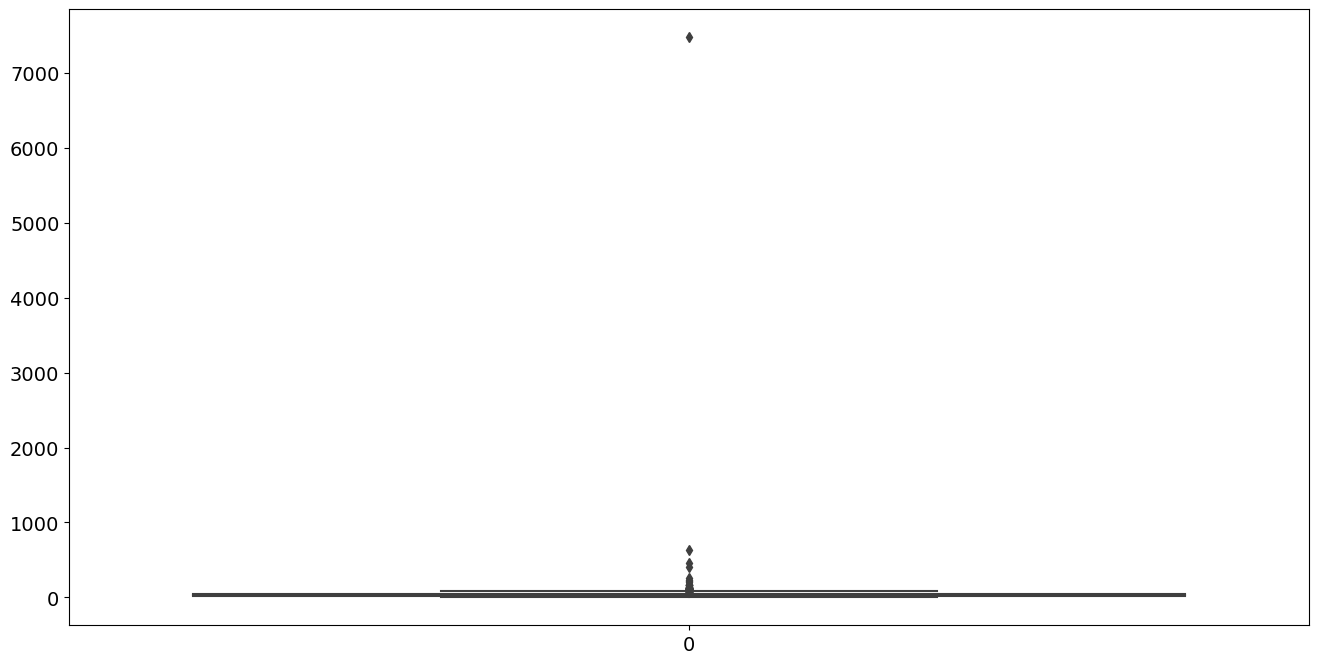

In [151]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['LifeSquare'], whis=1.5)

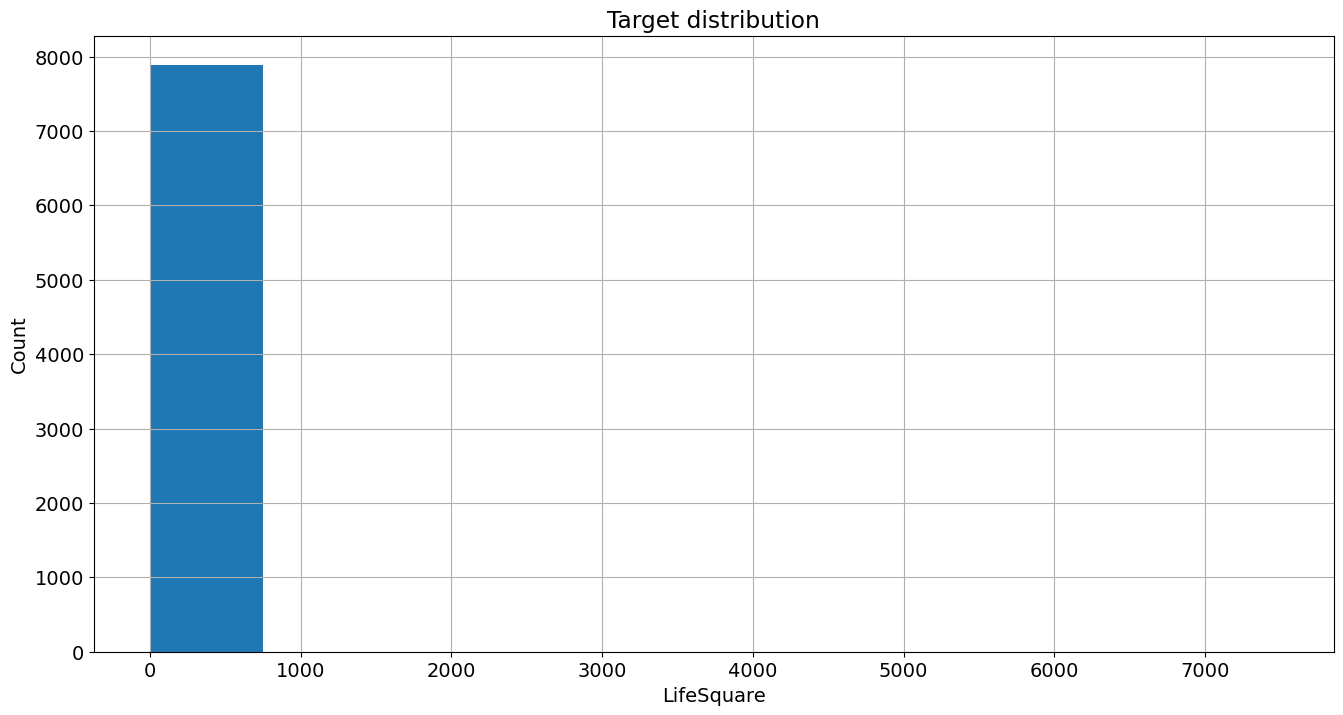

In [152]:
plt.figure(figsize=(16, 8))
train_df['LifeSquare'].hist(bins = 10)
plt.ylabel('Count')
plt.xlabel('LifeSquare')

plt.title('Target distribution')
plt.show()

<Axes: >

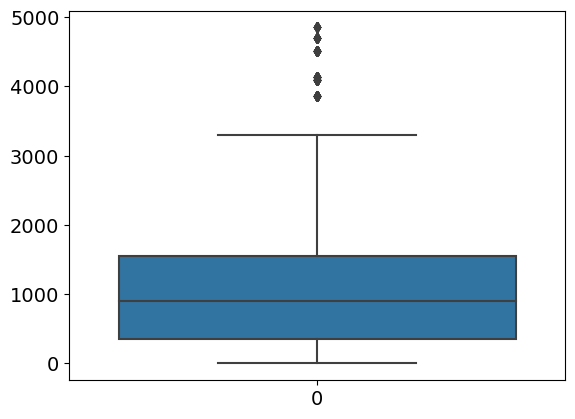

In [153]:
sns.boxplot(train_df['Healthcare_1'], whis=1.5)

### Наблюдение: 1) Есть пропущенные значения в признаках LifeSquare, Helthcare_1, 2) значения признаков имеют разный масштаб,  3) Есть странные значения в полях: HouseFloor - 0, Square и LifeSquare - 1.13 и 0.37, Rooms - 0; LifeSqure и KitchenSquare в некоторых случаях больше, чем Square; в некоторых случаях оч большое кол-во комнат - 19

### Посмотрим значения качественных переменных

In [154]:
train_df.select_dtypes(include='category').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

Альтерантивная функция поиска категориальных переменных или переменных, где есть ограниченное кол-во значений (<=3)

In [155]:
#def find_cat(data):
#    for name in data.columns:
#        s = ''
#        s += name
#        if (type(data[name]) == str):
#           s += ' string,'
#        if (data[name].nunique()<=3):
#            s += ' few unique values'
#        if (s!=name):
#            print(s)

In [156]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [157]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [158]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Посмотрим, как отличается распределение целевой переменной и ее медиана в зависимости от значения категориального признака

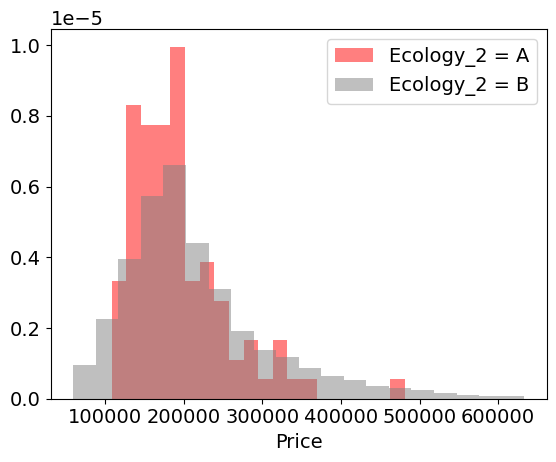

In [159]:
plt.hist(train_df.loc[train_df['Ecology_2']=='A','Price'], bins=20, density=True, color='Red', alpha=0.5, label='Ecology_2 = A')
plt.hist(train_df.loc[train_df['Ecology_2']=='B','Price'], bins=20, density=True, color='Gray', alpha=0.5, label='Ecology_2 = B')
plt.xlabel('Price')
plt.legend(loc='upper right')
plt.show()

In [160]:
train_df_cat = train_df.groupby('Ecology_2').median()['Price']
type(train_df_cat)
train_df_cat = pd.DataFrame(train_df_cat)

train_df_cat

,Price
Ecology_2,
A,182516.562500
B,192371.640625


In [161]:
train_df_cat = train_df.groupby('Ecology_2').median()
train_df_cat

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Ecology_2,,,,,,,,,,,,,,,,,
A,8758.0,101.0,2.0,47.387955,29.882507,6.0,5.0,5.0,1967.0,0.225825,41.0,6558.0,7.0,1548.0,3.0,2.0,182516.562500
B,8393.0,34.0,2.0,52.582016,32.810379,6.0,7.0,14.0,1977.0,0.072158,25.0,5285.0,2.0,900.0,1.0,3.0,192371.640625


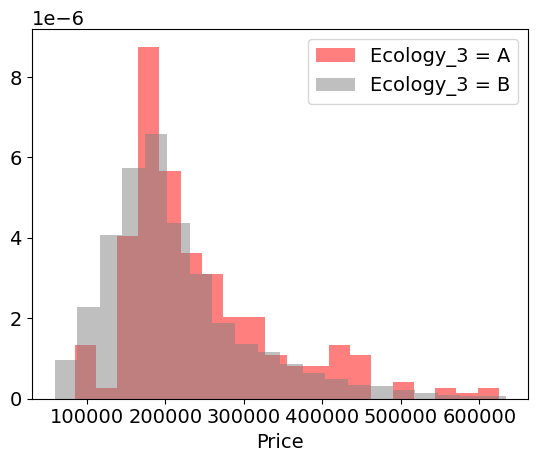

In [162]:
plt.hist(train_df.loc[train_df['Ecology_3']=='A','Price'], bins=20, density=True, color='Red', alpha=0.5, label='Ecology_3 = A')
plt.hist(train_df.loc[train_df['Ecology_3']=='B','Price'], bins=20, density=True, color='Gray', alpha=0.5, label='Ecology_3 = B')
plt.xlabel('Price')
plt.legend(loc='upper right')
plt.show()

In [163]:
train_df_cat = train_df.groupby('Ecology_3').median()['Price']
type(train_df_cat)
train_df_cat = pd.DataFrame(train_df_cat)
train_df_cat

,Price
Ecology_3,
A,211889.93750
B,191668.40625


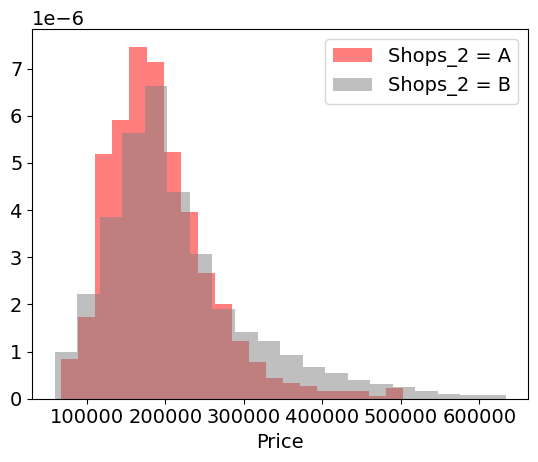

In [164]:
plt.hist(train_df.loc[train_df['Shops_2']=='A','Price'], bins=20, density=True, color='Red', alpha=0.5, label='Shops_2 = A')
plt.hist(train_df.loc[train_df['Shops_2']=='B','Price'], bins=20, density=True, color='Gray', alpha=0.5, label='Shops_2 = B')
plt.xlabel('Price')
plt.legend(loc='upper right')
plt.show()

In [165]:
train_df_cat = train_df.groupby('Shops_2').median()['Price']
type(train_df_cat)
train_df_cat = pd.DataFrame(train_df_cat)
train_df_cat

,Price
Shops_2,
A,181620.000
B,193446.125


### 3) Обработка данных на основе наблюдений (пропуски, выбросы, чистка ошибочных значений, удаление очевидно лишних признаков

In [166]:
train_df = train_df.drop('Id', axis =1 )

In [167]:
test_id = pd.DataFrame(test_df['Id'])

In [168]:
test_df = test_df.drop('Id', axis =1)

In [169]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

In [170]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [171]:
train_df[['Rooms', 'LifeSquare', 'Healthcare_1', 'HouseFloor']].median()

Rooms             2.000000
LifeSquare       32.781261
Healthcare_1    900.000000
HouseFloor       13.000000
dtype: float32

In [172]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor']

17       6
19      16
21      11
24       2
25      18
        ..
9960    15
9968    18
9970    18
9975    18
9996    13
Name: Floor, Length: 1825, dtype: int8

In [173]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Заполняем пропуски и убираем экстремальные значения

In [174]:
class Preproc:   
    
    def fit_emiss(self, data):
        
        # Задаем релятивные интервалы значений для обработки выбросов на основе анализа данных 
        self.Square_min = data['Square'].quantile(.025)
        self.Square_max = data['Square'].quantile(.975)
        
        self.LifeSquare_min = data['LifeSquare'].quantile(.025)
        self.LifeSquare_max = data['LifeSquare'].quantile(.975)
        
        self.KitchenSquare_min = data['KitchenSquare'].quantile(.025)
        self.KitchenSquare_max = data['KitchenSquare'].quantile(.975)
        
        
        # медианы
            
        self.emiss_median_Rooms = data['Rooms'].median()
        self.emiss_median_LifeSquare = data['LifeSquare'].median()
        self.emiss_median_Healthcare_1 = data['Healthcare_1'].median()
        self.emiss_median_HouseFloor = data['HouseFloor'].median()
        
        self.medians = data[['Rooms', 'LifeSquare', 'Healthcare_1', 'HouseFloor', 'KitchenSquare', 'Square']].median()
        

        
        # текущая дата
        self.current_year = datetime.now().year
        
        # подсчет средней цены за м2 по району
        data_temp = data.loc[((data['Square'] > self.Square_min) & (data['Square'] < self.Square_max))]
        data_temp["SquareMeterPrice"] = data_temp["Price"] / data_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = data_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        #self.emiss_floor_out = data.loc[data['Floor'] > data['HouseFloor']].index        
        #floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index 
    def transf_emiss(self, data):
       
    #Выбросы
        data.loc[(data['Rooms'] > 6) | (data['Rooms'] == 0), 'Rooms'] = self.medians['Rooms']
        data.loc[data['HouseFloor']==0, 'HouseFloor'] = self.medians['HouseFloor']
        data.loc[(data['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
            
        data.loc[(data['KitchenSquare'] > self.KitchenSquare_max) |
        (data['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.medians['KitchenSquare']
        data.loc[(data['LifeSquare'] > self.LifeSquare_max) |
        (data['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.medians['LifeSquare']
        data.loc[(data['Square'] > self.Square_max) | 
        (data['Square'] < self.Square_min), 'Square'] = self.medians['Square']
        
        #Обрабаытваем аномалии 
        #Убираем случаи, когда этаж больше, чем кол-во этажей в доме
        floor_outliers = data.loc[data['Floor'] > data['HouseFloor']].index
        
        data.loc[floor_outliers, 'Floor'] = data.loc[floor_outliers, 'HouseFloor'].apply(lambda x: 1 if (1 == x) else np.random.randint(1, x))
        
        #1 if (1 == x) else 
        #data.loc[floor_out, 'Floor'] = data.loc[floor_out, 'HouseFloor'].apply(lambda x: np.random.randint(1, x))       
        data.loc[data['KitchenSquare'] > data['Square'], 'KitchenSquare'] = data['Square']/5
        data.loc[data['LifeSquare'] > data['Square'], 'LifeSquare'] = data['Square']/1.5
        
                
        #Пропуски
        data[['LifeSquare', 'Healthcare_1']] = data[['LifeSquare', 'Healthcare_1']].fillna(self.medians[['LifeSquare', 'Healthcare_1']])
        
        
        #data['LifeSquare'] = data['LifeSquare'].fillna(self.emiss_median_LifeSquare)
        #data['Healthcare_1'] = data['Healthcare_1'].fillna(self.emiss_median_Healthcare_1)
    
        #Обработки категориальных переменных
        data = pd.concat([data, pd.get_dummies(data['Ecology_2'])], axis=1)
        data = data.rename(columns={'A':'Ecology_2_A', 'B':'Ecology_2_B'})
        data = pd.concat([data, pd.get_dummies(data['Ecology_3'])], axis=1)
        data = data.rename(columns={'A':'Ecology_3_A', 'B':'Ecology_3_B'})
        data = pd.concat([data, pd.get_dummies(data['Shops_2'])], axis=1)
        data = data.rename(columns={'A':'Shops_2_A', 'B':'Shops_2_B'})
        
        return data
    
    def features(self, data):
        
        # добавление признака популярности района
        #train_df['DistrictId_counts'] = train_df['DistrictId'].map(self.DistrictId_value_counts)
        #train_df['DistrictId_counts'].fillna(train_df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        data = data.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        data['AverageSquareMeterPrice'].fillna(data['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        #train_df = train_df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        #train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)
        
        return data


prep = Preproc()    
# тренировочные данные    
prep.fit_emiss(train_df)
train_df = prep.transf_emiss(train_df)
train_df = prep.features(train_df)

# тренировочные данные   
test_df = prep.transf_emiss(test_df)
test_df = prep.features(test_df)

In [176]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DistrictId               10000 non-null  int16   
 1   Rooms                    10000 non-null  float32 
 2   Square                   10000 non-null  float32 
 3   LifeSquare               10000 non-null  float32 
 4   KitchenSquare            10000 non-null  float32 
 5   Floor                    10000 non-null  int64   
 6   HouseFloor               10000 non-null  float32 
 7   HouseYear                10000 non-null  int32   
 8   Ecology_1                10000 non-null  float32 
 9   Ecology_2                10000 non-null  category
 10  Ecology_3                10000 non-null  category
 11  Social_1                 10000 non-null  int8    
 12  Social_2                 10000 non-null  int16   
 13  Social_3                 10000 non-null  int16   
 14  Healthc

In [125]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,AverageSquareMeterPrice
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888800,55.108601,33.683571,5.536700,7.336000,12.959100,1984.87320,0.118858,24.687000,...,1.319500,4.231300,214138.859375,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500,3893.987549
std,43.587592,0.812107,15.215080,10.827317,3.670604,5.034803,6.443573,18.41796,0.119025,17.532614,...,1.493601,4.806341,92872.273438,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139,947.069519
min,0.000000,1.000000,32.105270,5.927865,0.000000,1.000000,1.000000,1910.00000,0.000000,0.000000,...,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2298.367188
25%,20.000000,1.000000,42.432730,26.852563,1.000000,3.000000,9.000000,1974.00000,0.017647,6.000000,...,0.000000,1.000000,153872.628906,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,3016.560303
50%,36.000000,2.000000,52.513309,32.781261,6.000000,6.000000,13.000000,1977.00000,0.075424,25.000000,...,1.000000,3.000000,192269.648438,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4065.475342
75%,75.000000,2.000000,64.591721,37.269196,8.000000,10.000000,17.000000,2001.00000,0.195781,36.000000,...,2.000000,6.000000,249135.460938,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4484.526367
max,209.000000,6.000000,100.904266,80.577263,13.000000,42.000000,117.000000,2024.00000,0.521867,74.000000,...,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9452.113281


In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DistrictId               5000 non-null   int16   
 1   Rooms                    5000 non-null   float32 
 2   Square                   5000 non-null   float32 
 3   LifeSquare               5000 non-null   float32 
 4   KitchenSquare            5000 non-null   float32 
 5   Floor                    5000 non-null   int64   
 6   HouseFloor               5000 non-null   float32 
 7   HouseYear                5000 non-null   int16   
 8   Ecology_1                5000 non-null   float32 
 9   Ecology_2                5000 non-null   category
 10  Ecology_3                5000 non-null   category
 11  Social_1                 5000 non-null   int8    
 12  Social_2                 5000 non-null   int16   
 13  Social_3                 5000 non-null   int16   
 14  Healthca

In [126]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,AverageSquareMeterPrice
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.907800,55.435589,33.850109,5.57640,7.461800,12.941600,1984.392600,0.119874,24.933800,...,1029.396362,1.31940,4.242800,0.009600,0.990400,0.029800,0.970200,0.082400,0.917600,3910.975586
std,44.179466,0.810094,15.307028,10.736846,3.64026,5.150558,6.466835,18.573149,0.120070,17.532202,...,766.589233,1.47994,4.777365,0.097518,0.097518,0.170052,0.170052,0.275001,0.275001,937.682922
min,0.000000,1.000000,32.107594,5.948005,0.00000,1.000000,1.000000,1908.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2300.073486
25%,21.000000,1.000000,42.699547,27.340222,1.00000,4.000000,9.000000,1973.000000,0.019509,6.000000,...,810.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,3078.125244
50%,37.000000,2.000000,52.513309,32.781261,6.00000,6.000000,13.000000,1977.000000,0.072158,25.000000,...,900.000000,1.00000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4069.033691
75%,77.000000,2.000000,65.222521,37.798808,8.00000,11.000000,17.000000,2000.000000,0.195781,36.000000,...,990.000000,2.00000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4484.526367
max,212.000000,6.000000,100.867249,80.735138,13.00000,46.000000,99.000000,2020.000000,0.521867,74.000000,...,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9452.113281


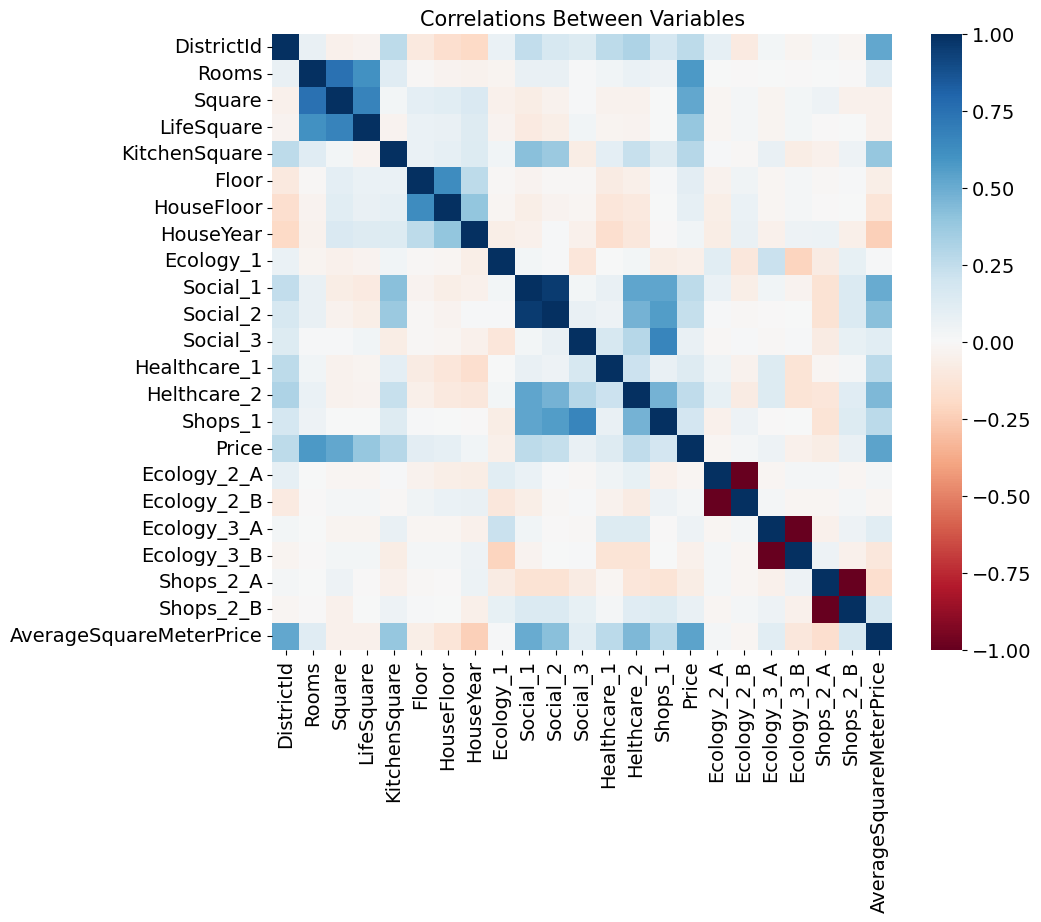

In [127]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

### Строим модель 

In [323]:
#feat = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']
x = train_df.drop(['Price', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
#x.head()
#x = train_df[feat]
y = train_df['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21)

In [64]:
x_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
9185,56,2.0,78.364532,36.151920,6.0,15,20.0,2018,0.000000,23,...,4,900.0,2,6,0,1,0,1,0,1
6945,8,2.0,47.699688,31.891401,5.0,8,9.0,1969,0.458174,26,...,1,1130.0,1,5,0,1,1,0,0,1
6615,47,2.0,55.038437,33.244614,8.0,4,12.0,1978,0.000070,46,...,1,240.0,1,16,0,1,0,1,0,1
9527,11,2.0,46.404854,31.859941,6.0,5,9.0,1977,0.038693,28,...,1,1015.0,2,5,0,1,0,1,0,1
4336,27,1.0,37.814663,25.209776,10.0,20,22.0,2019,0.211401,9,...,0,900.0,0,1,0,1,0,1,0,1


In [65]:
y_train.shape

(7000,)

### 1. Random Forest

In [153]:
forest = RandomForestRegressor()

In [154]:
forest.fit(x_train, y_train)

RandomForestRegressor()

Train R2:	0.957
Test R2:	0.743


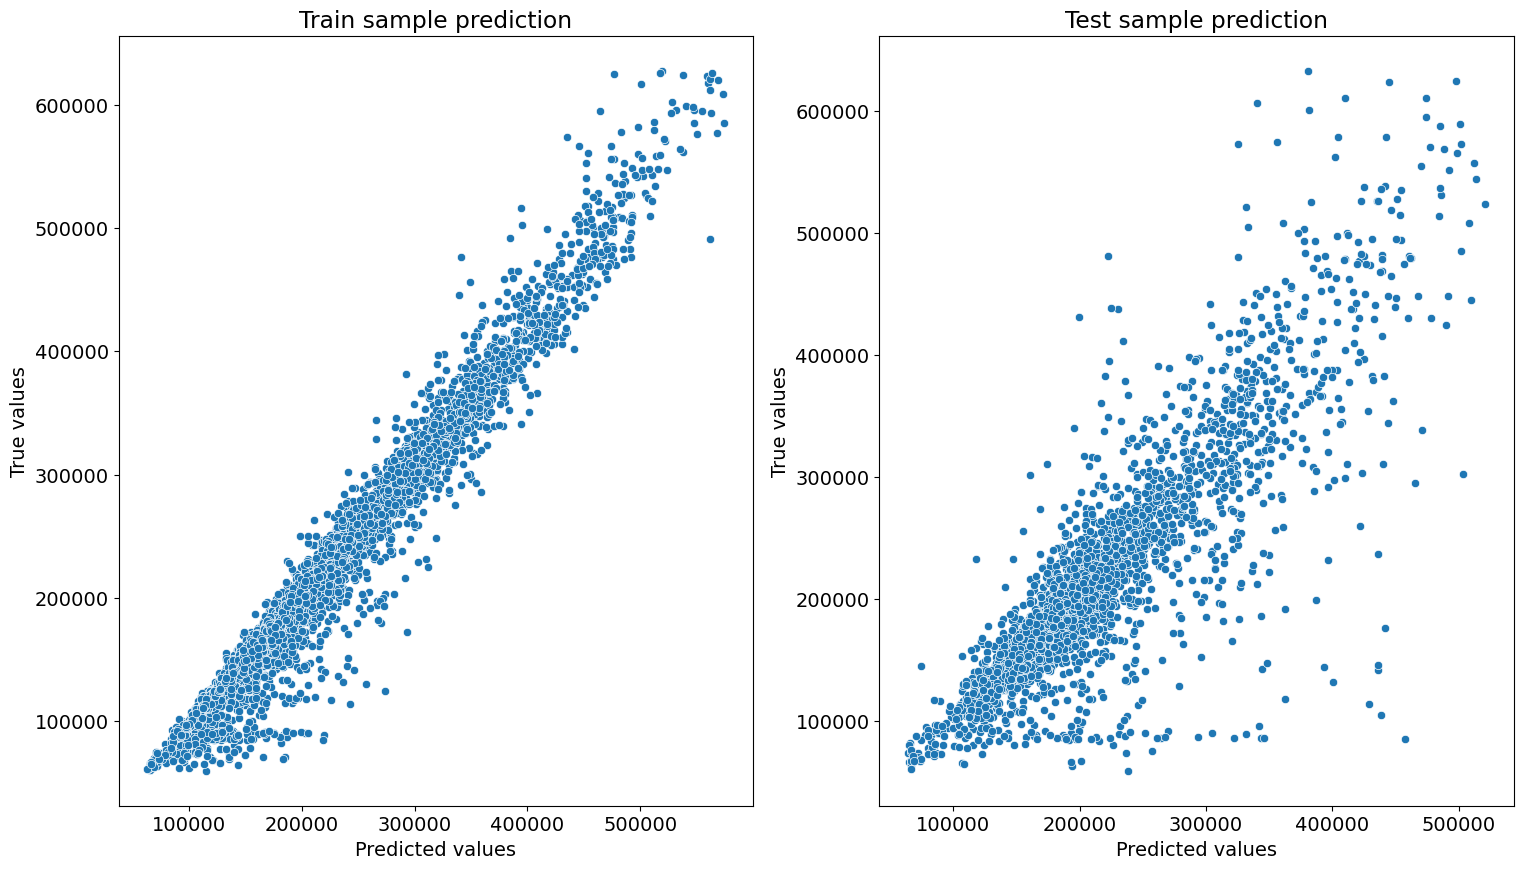

In [68]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

In [69]:
r2(y_train, train_pred )

0.9568469594189409

In [70]:
r2(y_test, test_pred)

0.7433171484542697

#### Используем GridSearch для поиска наиболее подходящих параметров

In [49]:
%%time
estimator=RandomForestRegressor(random_state=100)

CPU times: total: 0 ns
Wall time: 794 µs


In [73]:
parameters = [{'n_estimators': [60, 130], 'max_features': np.arange(2, 7), 'max_depth': np.arange(4, 40)}]

In [74]:
gs = GridSearchCV(estimator, param_grid=parameters, scoring='r2', cv=5 )

In [75]:
#%%time
#gs.fit(x_train, y_train)

In [76]:
#gs.best_params_

In [77]:
#final_model = RandomForestRegressor(n_estimators=100, max_features=4, max_depth=22, random_state=100)

In [324]:
final_model = RandomForestRegressor(n_estimators=1400, max_features=4, max_depth=17, random_state=100)

In [325]:
%%time
final_model.fit(x_train, y_train)

CPU times: total: 30.1 s
Wall time: 32.3 s


RandomForestRegressor(max_depth=17, max_features=4, n_estimators=1400,
                      random_state=100)

Train R2:	0.952
Test R2:	0.768


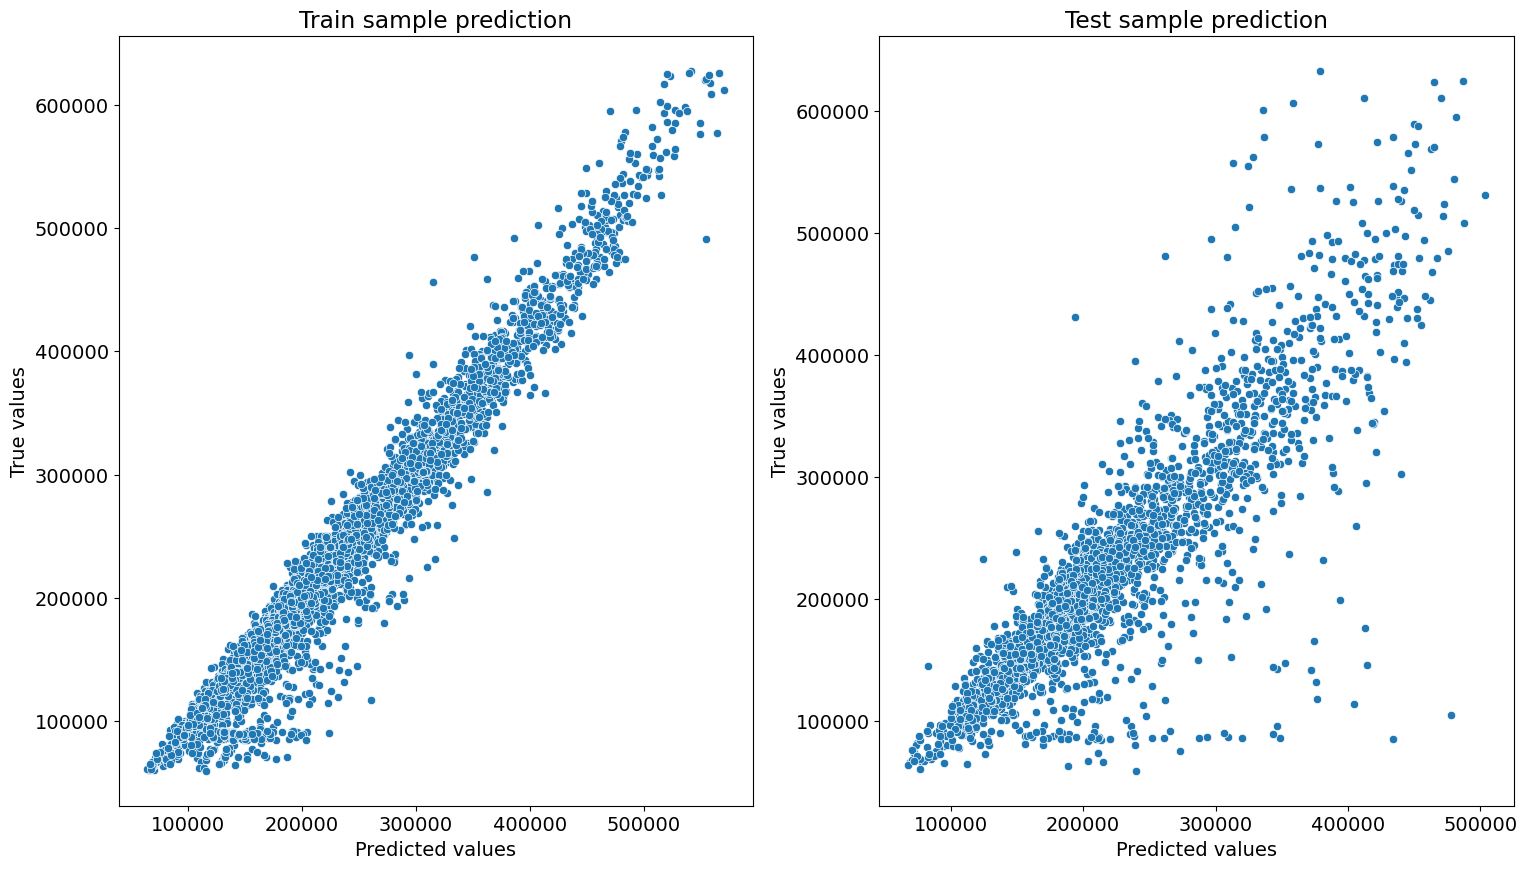

In [326]:
train_pred_final = final_model.predict(x_train)
test_pred_final = final_model.predict(x_test)
evaluate_preds(y_train, train_pred_final, y_test, test_pred_final)

#### Случайный лес показал хороший результат, попробуем другие модели.

## Попробуем модель градиентного бустинга

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

Train R2:	0.864
Test R2:	0.757


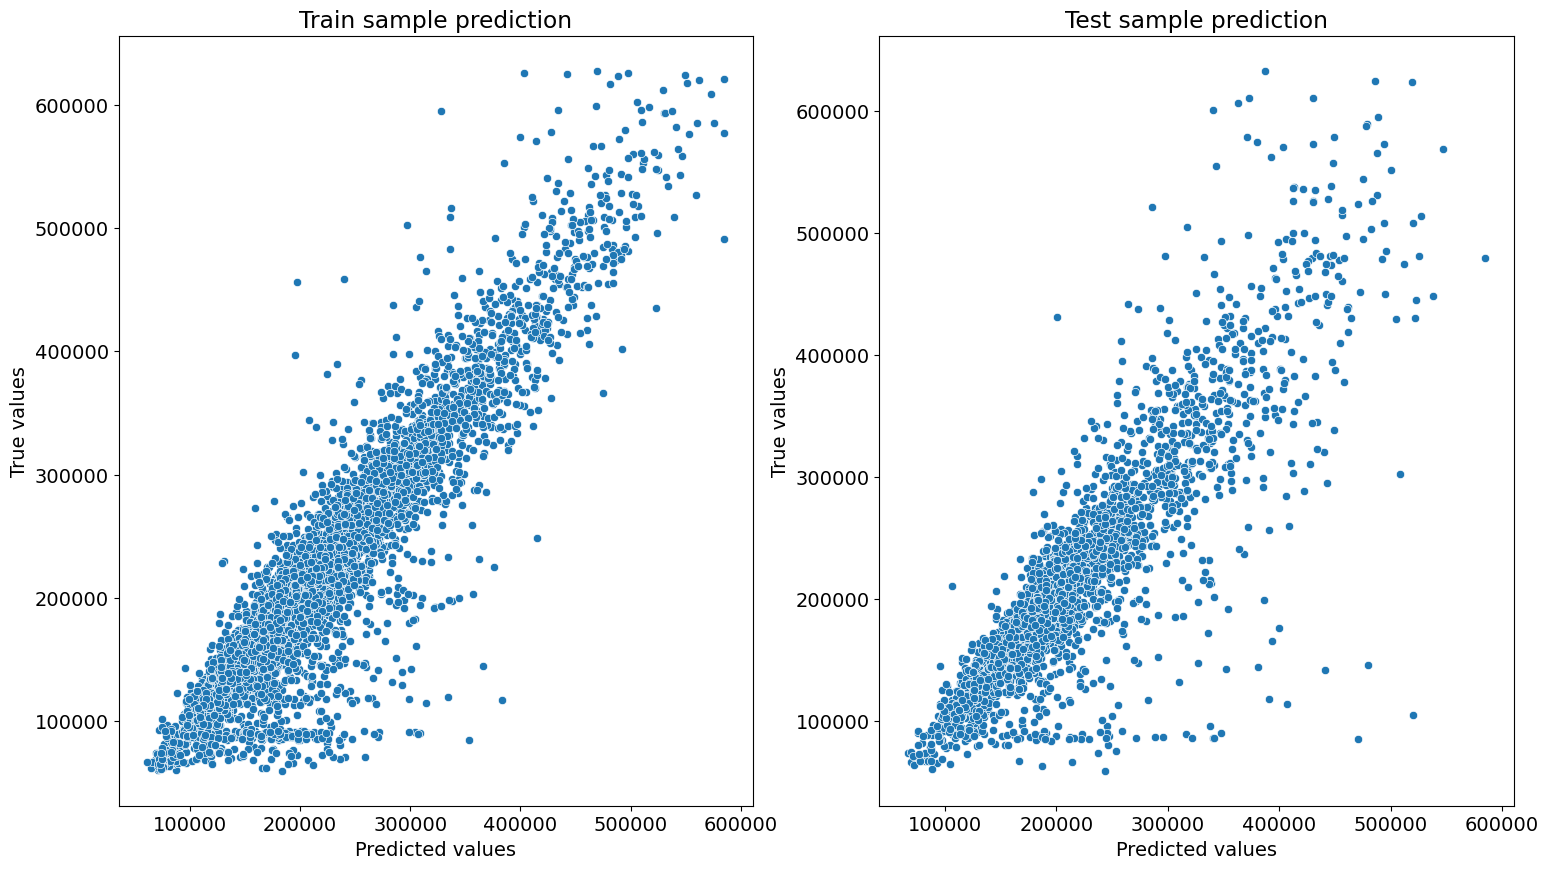

In [177]:
gb_model = GradientBoostingRegressor(criterion='squared_error',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=130,
                                     max_features=3)
gb_model.fit(x_train, y_train)

y_train_preds_gb = gb_model.predict(x_train)

y_test_preds_gb = gb_model.predict(x_test)
evaluate_preds(y_train, y_train_preds_gb, y_test, y_test_preds_gb)

#### Используем GridSearch для поиска наиболее подходящих параметров

In [88]:
%%time
estimator=GradientBoostingRegressor(random_state=42)

CPU times: total: 0 ns
Wall time: 0 ns


In [163]:
parameters_gb = [{'n_estimators': [60, 200], 'max_features': np.arange(4, 7), 'max_depth': np.arange(4, 15)}]

In [164]:
gs_gb = GridSearchCV(estimator, param_grid=parameters, scoring='r2', cv=5 )

In [167]:
%%time
gs_gb.fit(x_train, y_train)

CPU times: total: 59min 39s
Wall time: 1h 2min 33s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid=[{'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39]),
                          'max_features': array([2, 3, 4, 5, 6]),
                          'n_estimators': [60, 130]}],
             scoring='r2')

In [168]:
gs_gb.best_params_

{'max_depth': 7, 'max_features': 3, 'n_estimators': 130}

Train R2:	0.906
Test R2:	0.755


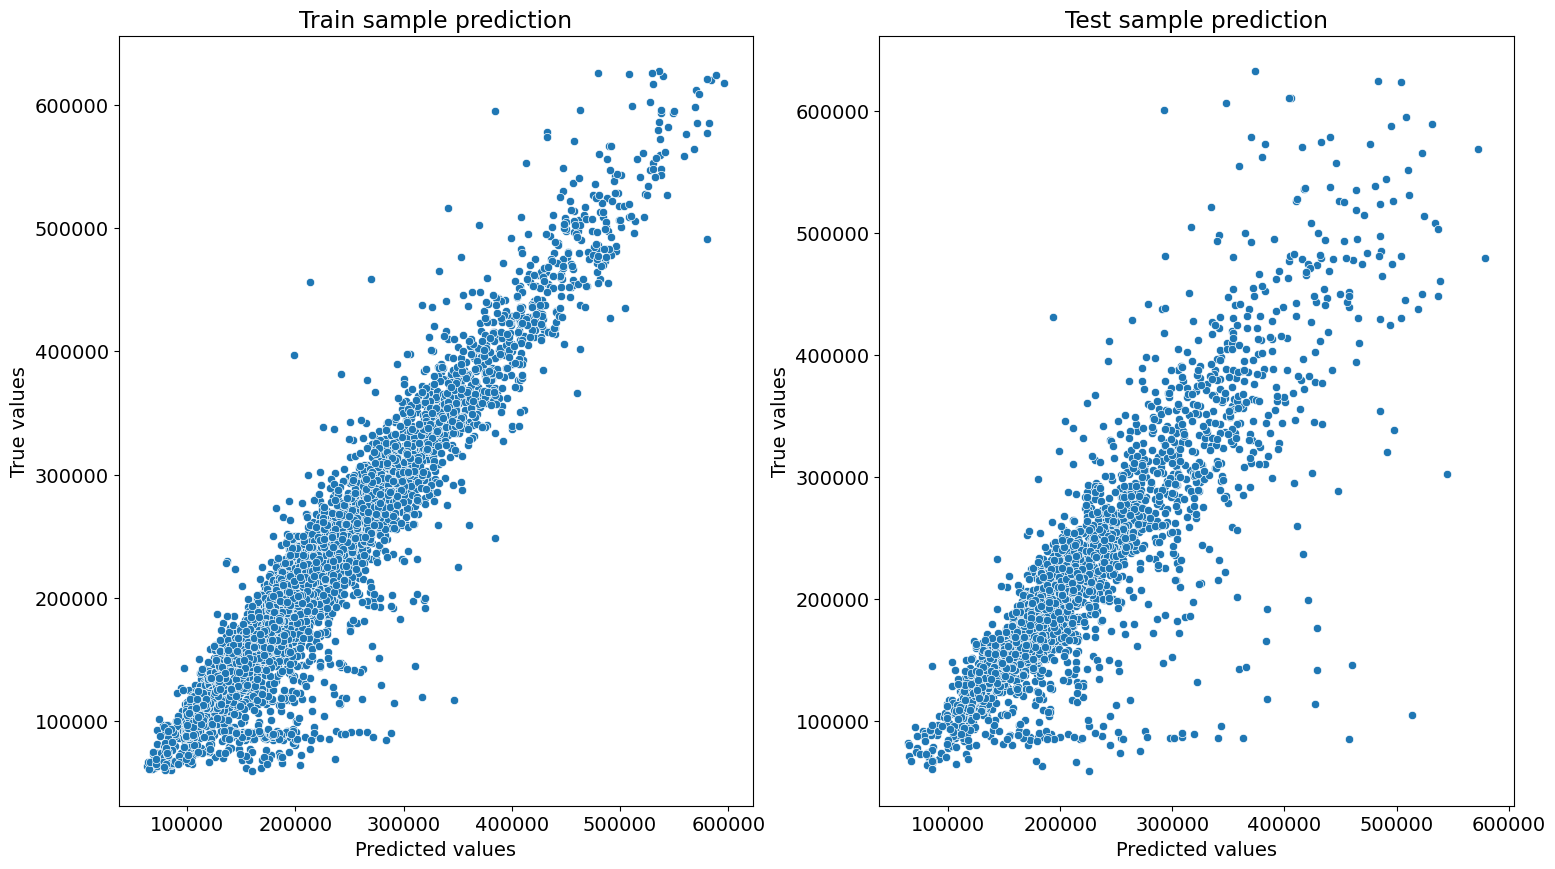

In [120]:
gb_model = GradientBoostingRegressor(criterion='squared_error',
                                     max_depth=8,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=130,
                                     max_features=5)
gb_model.fit(x_train, y_train)

y_train_preds_gb = gb_model.predict(x_train)

y_test_preds_gb = gb_model.predict(x_test)
evaluate_preds(y_train, y_train_preds_gb, y_test, y_test_preds_gb)

#### Градиентный бустинг тоже справился хорошо, но несколько хуже, чем случайный лес

## Попробуем модель линейной регрессии

Стандартизируем данные

In [244]:
feature_names_for_stand = train_df.select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1',
 'Price']

In [245]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train_df[feature_names_for_stand])

In [246]:
train_df_stand = train_df
train_df_stand[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

Разделим выборку на трейн и тест

In [168]:
x = train_df_stand.drop(['Price', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
y = train_df_stand['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21)

In [169]:
train_df_stand.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,...,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,4.899502e-08,5.173683e-09,1.482844e-07,-4.632994e-08,7.384500,-1.536608e-08,3.990166e+03,7.546693e-09,24.687000,...,-3.588200e-09,1.319500,4.231300,-1.202226e-08,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,1.000026e+00,1.000051e+00,1.000042e+00,1.000046e+00,5.019859,1.000069e+00,2.005003e+05,1.000047e+00,17.532614,...,1.000053e+00,1.493601,4.806341,1.000050e+00,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,-1.094506e+00,-1.511955e+00,-1.776313e+00,-1.158744e+00,1.000000,-1.856099e+00,1.910000e+03,-9.986406e-01,0.000000,...,-1.374664e+00,0.000000,0.000000,-1.668655e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,-1.094506e+00,-8.331553e-01,-6.179374e-01,-1.158744e+00,3.000000,-6.144677e-01,1.974000e+03,-8.503701e-01,6.000000,...,-2.629952e-01,0.000000,1.000000,-6.489475e-01,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,1.369364e-01,-1.705823e-01,-7.943056e-02,-8.523651e-02,6.000000,6.347838e-03,1.977000e+03,-3.649310e-01,25.000000,...,-1.692400e-01,1.000000,3.000000,-2.354879e-01,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,1.369364e-01,6.233035e-01,3.203740e-01,6.304353e-01,10.250000,6.271634e-01,2.001000e+03,6.463113e-01,36.000000,...,-4.869764e-02,2.000000,6.000000,3.768439e-01,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,5.062706e+00,3.010042e+00,4.308643e+00,2.419615e+00,42.000000,1.614755e+01,2.005201e+07,3.386085e+00,74.000000,...,5.119891e+00,6.000000,23.000000,4.512815e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [170]:
lr = LinearRegression()

In [171]:
lr.fit(x_train, y_train)

LinearRegression()

Train R2:	0.49
Test R2:	0.508


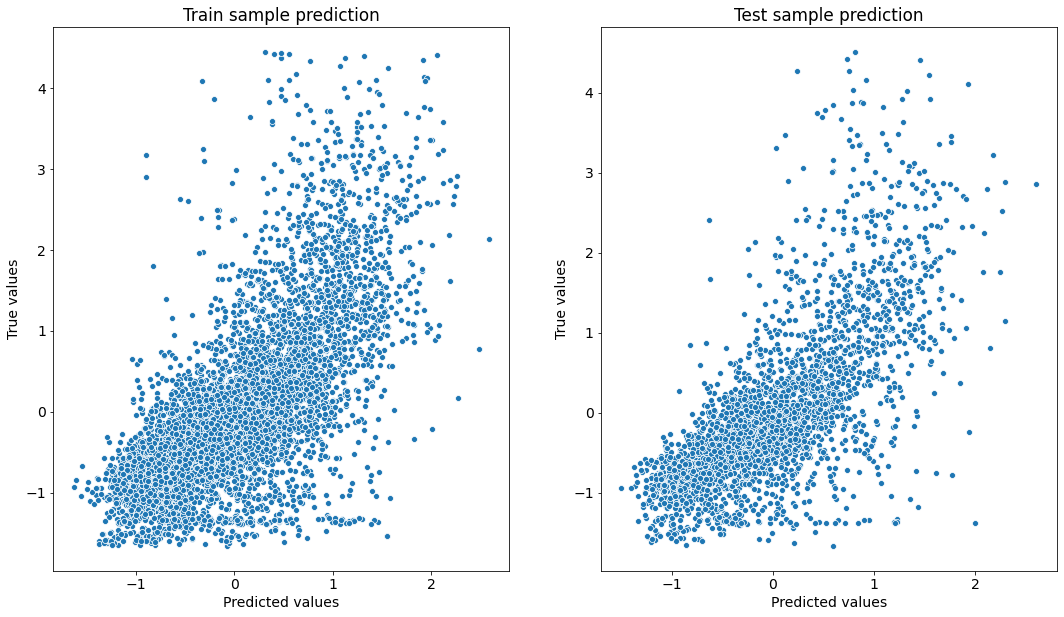

In [172]:
train_pred = lr.predict(x_train)
test_pred = lr.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

#### Линейная регрессия справилась значительно хуже случайного леса и градиентного бустинга

## Итоговое предсказание

In [327]:
final_model.fit(x, y)

RandomForestRegressor(max_depth=17, max_features=4, n_estimators=1400,
                      random_state=100)

In [328]:
itog_test = test_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)

In [329]:
itog_test.shape

(5000, 22)

In [330]:
pred = pd.DataFrame(final_model.predict(itog_test), columns=['pred'])
pred

,pred
0,159177.391665
1,117724.544417
2,140853.523054
3,159482.656012
4,182460.703396
...,...
4995,169315.798412
4996,400186.194238
4997,148005.543591
4998,187988.218976


In [331]:
result = test_id.copy()
result['Price'] = pred.copy()

In [175]:
result.head()

,Id,Price
0,4567,163448.970789
1,5925,125715.030421
2,960,144373.434376
3,3848,153469.201471
4,746,199447.517861


In [332]:
result.to_csv('Posadskov_predict_v7.csv', index=False)

In [172]:
help(pd.DataFrame.to_csv)

Help on function to_csv in module pandas.core.generic:

to_csv(self, path_or_buf: Union[str, pathlib.Path, IO[~AnyStr], NoneType] = None, sep: str = ',', na_rep: str = '', float_format: Union[str, NoneType] = None, columns: Union[Sequence[Union[Hashable, NoneType]], NoneType] = None, header: Union[bool, List[str]] = True, index: bool = True, index_label: Union[bool, str, Sequence[Union[Hashable, NoneType]], NoneType] = None, mode: str = 'w', encoding: Union[str, NoneType] = None, compression: Union[str, Mapping[str, str], NoneType] = 'infer', quoting: Union[int, NoneType] = None, quotechar: str = '"', line_terminator: Union[str, NoneType] = None, chunksize: Union[int, NoneType] = None, date_format: Union[str, NoneType] = None, doublequote: bool = True, escapechar: Union[str, NoneType] = None, decimal: Union[str, NoneType] = '.') -> Union[str, NoneType]
    Write object to a comma-separated values (csv) file.
    
    .. versionchanged:: 0.24.0
        The order of arguments for Series 

In [179]:
help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model._base:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, default=True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, default=False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean 